In [1]:
import numpy as np
import ROOT as rt
import uproot

Welcome to JupyROOT 6.12/07


In [2]:
# Expecting 540629 qcdSigExt events
# qcdSigExt
# h_t_bin_content = [201768.0, 120440.0, 73590.0, 47403.0, 30366.0, 20378.0, 13591.0, 
#                    9490.0, 6295.0, 4591.0, 3336.0, 2332.0, 1740.0, 1354.0, 1004.0, 
#                    710.0, 537.0, 401.0, 274.0, 243.0, 177.0, 148.0, 99.0, 77.0, 56.0, 
#                    43.0, 39.0, 24.0, 22.0, 23.0]
# h_a_bin_content = [1782.0, 1103.0, 786.0, 491.0, 291.0, 195.0, 120.0, 88.0, 53.0, 60.0, 
#                    32.0, 24.0, 19.0, 11.0, 3.0, 4.0, 11.0, 3.0, 4.0, 6.0, 2.0, 5.0, 1.0, 
#                    1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
# h_r_bin_content = [199986.0, 119337.0, 72804.0, 46912.0, 30075.0, 20183.0, 13471.0, 9402.0, 
#                    6242.0, 4531.0, 3304.0, 2308.0, 1721.0, 1343.0, 1001.0, 706.0, 526.0, 398.0, 
#                    270.0, 237.0, 175.0, 143.0, 98.0, 76.0, 55.0, 42.0, 38.0, 24.0, 22.0, 23.0]
# # xsec BSM = 1.00E+1
# # Expecting 11281 GtoWW3 events
# # GtoWW3
# h_t_signal = [61.0, 66.0, 100.0, 126.0, 142.0, 213.0, 218.0, 294.0, 356.0, 398.0, 438.0, 438.0, 
#               499.0, 548.0, 484.0, 504.0, 499.0, 524.0, 505.0, 510.0, 525.0, 629.0, 706.0, 764.0, 
#               826.0, 563.0, 219.0, 49.0, 23.0, 14.0]
# h_a_signal = [28.0, 35.0, 44.0, 63.0, 74.0, 109.0, 92.0, 109.0, 124.0, 128.0, 109.0, 86.0, 68.0, 
#               53.0, 23.0, 24.0, 17.0, 10.0, 16.0, 9.0, 7.0, 10.0, 14.0, 15.0, 14.0, 11.0, 6.0, 2.0, 
#               0.0, 0.0]
# h_r_signal = [33.0, 31.0, 56.0, 63.0, 68.0, 104.0, 126.0, 185.0, 232.0, 270.0, 329.0, 352.0, 431.0, 
#               495.0, 461.0, 480.0, 482.0, 514.0, 489.0, 501.0, 518.0, 619.0, 692.0, 749.0, 812.0, 
#               552.0, 213.0, 47.0, 23.0, 14.0]

# #Expecting 13228 GtoTTBroad events
# #GtoTTBroad

# h_t_bin_content = [201500.0, 120814.0, 73913.0, 47602.0, 30427.0, 20479.0, 13670.0, 9510.0, 6480.0, 4554.0, 3173.0, 2317.0, 1702.0, 1198.0, 945.0, 731.0, 563.0, 390.0, 292.0, 229.0, 199.0, 133.0, 108.0, 98.0, 67.0, 58.0, 33.0, 32.0, 33.0, 24.0]
# h_a_bin_content = [1865.0, 1234.0, 806.0, 521.0, 292.0, 189.0, 118.0, 97.0, 63.0, 46.0, 32.0, 25.0, 20.0, 14.0, 1.0, 7.0, 6.0, 1.0, 4.0, 0.0, 1.0, 3.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
# h_r_bin_content = [199635.0, 119580.0, 73107.0, 47081.0, 30135.0, 20290.0, 13552.0, 9413.0, 6417.0, 4508.0, 3141.0, 2292.0, 1682.0, 1184.0, 944.0, 724.0, 557.0, 389.0, 288.0, 229.0, 198.0, 130.0, 108.0, 98.0, 67.0, 57.0, 33.0, 32.0, 33.0, 24.0]

# h_t_signal = [66.0, 68.0, 115.0, 140.0, 186.0, 241.0, 284.0, 323.0, 500.0, 583.0, 701.0, 743.0, 814.0, 898.0, 913.0, 931.0, 876.0, 861.0, 796.0, 677.0, 639.0, 561.0, 434.0, 346.0, 180.0, 140.0, 84.0, 38.0, 26.0, 13.0]
# h_a_signal = [11.0, 17.0, 20.0, 37.0, 39.0, 76.0, 65.0, 84.0, 118.0, 126.0, 145.0, 123.0, 106.0, 115.0, 82.0, 67.0, 40.0, 39.0, 27.0, 13.0, 12.0, 18.0, 13.0, 8.0, 7.0, 5.0, 7.0, 4.0, 4.0, 1.0]
# h_r_signal = [55.0, 51.0, 95.0, 103.0, 147.0, 165.0, 219.0, 239.0, 382.0, 457.0, 556.0, 620.0, 708.0, 783.0, 831.0, 864.0, 836.0, 822.0, 769.0, 664.0, 627.0, 543.0, 421.0, 338.0, 173.0, 135.0, 77.0, 34.0, 22.0, 12.0]

# #GtoTTBroad another trial
# h_t_bin_content = [201851.0, 120840.0, 74150.0, 47192.0, 30466.0, 20266.0, 13735.0, 9432.0, 6738.0, 4478.0, 3095.0, 2285.0, 1610.0, 1237.0, 1023.0, 699.0, 533.0, 409.0, 300.0, 232.0, 152.0, 125.0, 106.0, 77.0, 64.0, 53.0, 42.0, 25.0, 34.0, 19.0]
# h_a_bin_content = [1826.0, 1100.0, 789.0, 515.0, 328.0, 180.0, 118.0, 85.0, 75.0, 50.0, 33.0, 29.0, 12.0, 17.0, 13.0, 6.0, 6.0, 4.0, 4.0, 4.0, 1.0, 1.0, 2.0, 3.0, 3.0, 1.0, 0.0, 1.0, 0.0, 0.0]
# h_r_bin_content = [200025.0, 119740.0, 73361.0, 46677.0, 30138.0, 20086.0, 13617.0, 9347.0, 6663.0, 4428.0, 3062.0, 2256.0, 1598.0, 1220.0, 1010.0, 693.0, 527.0, 405.0, 296.0, 228.0, 151.0, 124.0, 104.0, 74.0, 61.0, 52.0, 42.0, 24.0, 34.0, 19.0]

# h_t_signal = [73.0, 86.0, 100.0, 137.0, 192.0, 241.0, 284.0, 333.0, 453.0, 530.0, 662.0, 778.0, 838.0, 846.0, 848.0, 868.0, 883.0, 892.0, 842.0, 745.0, 649.0, 564.0, 473.0, 358.0, 212.0, 135.0, 70.0, 31.0, 23.0, 11.0]
# h_a_signal = [20.0, 15.0, 15.0, 42.0, 44.0, 57.0, 57.0, 83.0, 117.0, 99.0, 149.0, 130.0, 105.0, 107.0, 80.0, 58.0, 51.0, 38.0, 25.0, 32.0, 22.0, 13.0, 15.0, 10.0, 6.0, 8.0, 4.0, 0.0, 2.0, 0.0]
# h_r_signal = [53.0, 71.0, 85.0, 95.0, 148.0, 184.0, 227.0, 250.0, 336.0, 431.0, 513.0, 648.0, 733.0, 739.0, 768.0, 810.0, 832.0, 854.0, 817.0, 713.0, 627.0, 551.0, 458.0, 348.0, 206.0, 127.0, 66.0, 31.0, 21.0, 11.0]

# Flat loss cut
h_t_bin_content = [201668.0, 121132.0, 73949.0, 47509.0, 30238.0, 20305.0, 13600.0, 9373.0, 6537.0, 4608.0, 3163.0, 2331.0, 1743.0, 1238.0, 983.0, 682.0, 588.0, 391.0, 284.0, 228.0, 167.0, 154.0, 100.0, 71.0, 60.0, 62.0, 47.0, 30.0, 25.0, 18.0]
h_a_bin_content = [148.0, 236.0, 279.0, 340.0, 373.0, 427.0, 421.0, 399.0, 421.0, 395.0, 286.0, 267.0, 242.0, 215.0, 170.0, 144.0, 147.0, 86.0, 80.0, 56.0, 59.0, 49.0, 30.0, 22.0, 23.0, 14.0, 23.0, 14.0, 11.0, 7.0]
h_r_bin_content = [201520.0, 120896.0, 73670.0, 47169.0, 29865.0, 19878.0, 13179.0, 8974.0, 6116.0, 4213.0, 2877.0, 2064.0, 1501.0, 1023.0, 813.0, 538.0, 441.0, 305.0, 204.0, 172.0, 108.0, 105.0, 70.0, 49.0, 37.0, 48.0, 24.0, 16.0, 14.0, 11.0]

h_t_signal = [69.0, 74.0, 113.0, 137.0, 144.0, 227.0, 265.0, 370.0, 467.0, 561.0, 649.0, 751.0, 828.0, 857.0, 902.0, 936.0, 856.0, 830.0, 839.0, 734.0, 690.0, 568.0, 484.0, 323.0, 211.0, 135.0, 65.0, 44.0, 27.0, 18.0]
h_a_signal = [3.0, 6.0, 16.0, 32.0, 33.0, 93.0, 116.0, 195.0, 273.0, 354.0, 431.0, 538.0, 582.0, 619.0, 696.0, 708.0, 660.0, 667.0, 655.0, 610.0, 581.0, 482.0, 426.0, 285.0, 185.0, 125.0, 58.0, 42.0, 23.0, 17.0]
h_r_signal = [66.0, 68.0, 97.0, 105.0, 111.0, 134.0, 149.0, 175.0, 194.0, 207.0, 218.0, 213.0, 246.0, 238.0, 206.0, 228.0, 196.0, 163.0, 184.0, 124.0, 109.0, 86.0, 58.0, 38.0, 26.0, 10.0, 7.0, 2.0, 4.0, 1.0]

bin_edges = np.linspace(1100,4000,31)

n_bins = len(bin_edges)-1
max_bin = bin_edges[-1]
min_bin = bin_edges[0]

In [3]:
# prepare histograms and scale
background_hist_acc = rt.TH1D('background_acc','background_acc', n_bins, min_bin, max_bin)
signal_hist_acc = rt.TH1D('signal_acc','signal_acc', n_bins, min_bin, max_bin)
data_hist_acc = rt.TH1D('data_obs_acc','data_obs_acc', n_bins, min_bin, max_bin)

background_hist_rej = rt.TH1D('background_rej','background_rej', n_bins, min_bin, max_bin)
signal_hist_rej = rt.TH1D('signal_rej','signal_rej', n_bins, min_bin, max_bin)
data_hist_rej = rt.TH1D('data_obs_rej','data_obs_rej', n_bins, min_bin, max_bin)

for i, b in enumerate(h_a_bin_content):
    background_hist_acc.SetBinContent(i+1, b)
    data_hist_acc.SetBinContent(i+1, b)
for i, s in enumerate(h_a_signal):
    signal_hist_acc.SetBinContent(i+1, s)
    
for i, b in enumerate(h_r_bin_content):
    background_hist_rej.SetBinContent(i+1, b)
    data_hist_rej.SetBinContent(i+1, b)
for i, s in enumerate(h_r_signal):
    signal_hist_rej.SetBinContent(i+1, s)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


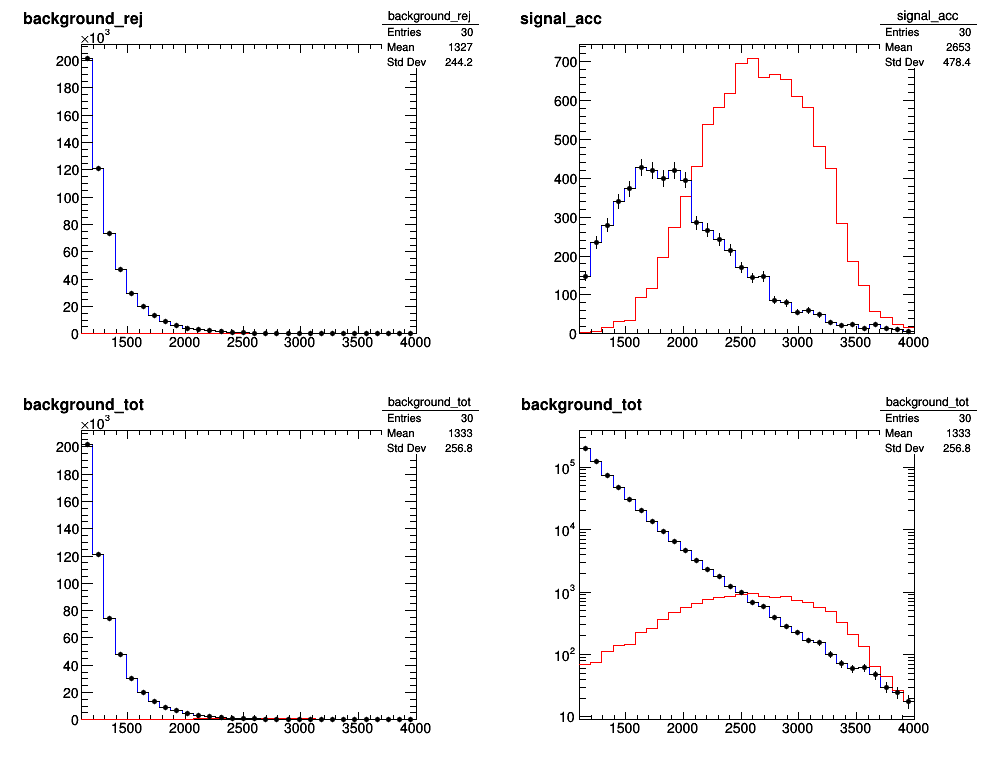

In [25]:
# plot background, signal, data
c = rt.TCanvas('c','c',1000,800)
c.Divide(2,2)

c.cd(1)
background_hist_rej.SetLineColor(rt.kBlue)
background_hist_rej.Draw('hist')
signal_hist_rej.SetLineColor(rt.kRed)
signal_hist_rej.Draw('histsame')
data_hist_rej.SetLineColor(rt.kBlack)
data_hist_rej.SetMarkerColor(rt.kBlack)
data_hist_rej.SetMarkerStyle(20)
data_hist_rej.SetMarkerSize(0.5)
data_hist_rej.Draw('pezsame')

c.cd(2)
signal_hist_acc.SetLineColor(rt.kRed)
signal_hist_acc.Draw('hist')
background_hist_acc.SetLineColor(rt.kBlue)
background_hist_acc.Draw('histsame')

data_hist_acc.SetLineColor(rt.kBlack)
data_hist_acc.SetMarkerColor(rt.kBlack)
data_hist_acc.SetMarkerStyle(20)
data_hist_acc.SetMarkerSize(0.5)
data_hist_acc.Draw('pezsame')

c.cd(3)
background_hist_tot.SetLineColor(rt.kBlue)
background_hist_tot.Draw('hist')
signal_hist_tot.SetLineColor(rt.kRed)
signal_hist_tot.Draw('histsame')
data_hist_tot.SetLineColor(rt.kBlack)
data_hist_tot.SetMarkerColor(rt.kBlack)
data_hist_tot.SetMarkerStyle(20)
data_hist_tot.SetMarkerSize(0.5)
data_hist_tot.Draw('pezsame')

c.cd(4)
rt.gPad.SetLogy()
background_hist_tot.SetLineColor(rt.kBlue)
background_hist_tot.Draw('hist')
signal_hist_tot.SetLineColor(rt.kRed)
signal_hist_tot.Draw('histsame')
data_hist_tot.SetLineColor(rt.kBlack)
data_hist_tot.SetMarkerColor(rt.kBlack)
data_hist_tot.SetMarkerStyle(20)
data_hist_tot.SetMarkerSize(0.5)
data_hist_tot.Draw('pezsame')
c.Draw()

In [5]:
# set up workspace

datacard_ws = rt.TFile.Open('datacard_ws.root','recreate')
w = rt.RooWorkspace('w','w')
x = rt.RooRealVar('x','x',min_bin,max_bin)
w.factory('x[%.1f,%.1f]'%(min_bin, max_bin))

acc_bin_functions = rt.RooArgList()
rej_bin_functions = rt.RooArgList()
w.factory('eff[%f,0,1]'%(background_hist_acc.Integral()/background_hist_rej.Integral()))
w.var('eff').setConstant(True)

empty_hist = rt.TH1D('empty_hist','empty_hist', n_bins, min_bin, max_bin)
for iBinX in range(1,n_bins+1):
    empty_hist.SetBinContent(iBinX,1)
    w.factory('crBin%i_In[%.1f]'%(iBinX,background_hist_rej.GetBinContent(iBinX)))
    w.factory('crBin%i[0,-100,100]'%(iBinX))
    w.var('crBin%i_In'%iBinX).setConstant(True)
    w.var('crBin%i'%iBinX).setConstant(False)
    w.factory("expr::crBin%iFunc('max(0,@0*pow(1.0+%f,@1))',crBin%i_In,crBin%i)"%(iBinX,1/rt.TMath.Sqrt(background_hist_rej.GetBinContent(iBinX)),iBinX,iBinX))
    w.factory("expr::bin%iFunc('max(0,@0*@1)',eff,crBin%iFunc)"%(iBinX,iBinX))
    rej_bin_functions.add(w.function('crBin%iFunc'%iBinX))
    acc_bin_functions.add(w.function('bin%iFunc'%iBinX))
    
qcd_rph_rej = rt.RooParametricHist('background_rej','background_acc',w.var('x'),rej_bin_functions,empty_hist)
qcd_rph_rej_norm = rt.RooAddition('background_rej_norm','background_rej_norm',rej_bin_functions)
qcd_rph_acc = rt.RooParametricHist('background_acc','background_acc',w.var('x'),acc_bin_functions,empty_hist)
qcd_rph_acc_norm = rt.RooAddition('background_acc_norm','background_acc_norm',acc_bin_functions)
getattr(w,'import')(qcd_rph_rej, rt.RooCmdArg())
getattr(w,'import')(qcd_rph_rej_norm, rt.RooFit.RecycleConflictNodes())
getattr(w,'import')(qcd_rph_acc, rt.RooCmdArg())
getattr(w,'import')(qcd_rph_acc_norm, rt.RooFit.RecycleConflictNodes())

ds_signal_acc = rt.RooDataHist('signal_acc','signal_acc',rt.RooArgList(w.var('x')),signal_hist_acc)
ds_signal_rej = rt.RooDataHist('signal_rej','signal_rej',rt.RooArgList(w.var('x')),signal_hist_rej)
getattr(w,'import')(ds_signal_acc, rt.RooCmdArg())
getattr(w,'import')(ds_signal_rej, rt.RooCmdArg())

ds_data_acc = rt.RooDataHist('data_obs_acc','data_obs_acc',rt.RooArgList(w.var('x')),data_hist_acc)
ds_data_rej = rt.RooDataHist('data_obs_rej','data_obs_rej',rt.RooArgList(w.var('x')),data_hist_rej)
getattr(w,'import')(ds_data_acc, rt.RooCmdArg())
getattr(w,'import')(ds_data_rej, rt.RooCmdArg())

datacard_ws.cd()
w.Write()
datacard_ws.Close()

w.Print('v')

[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooParametricHist::background_rej
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooFormulaVar::crBin1Func for import of RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooRealVar::crBin1_In for import of RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooRealVar::crBin1 for import of RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooFormulaVar::crBin2Func for import of RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooRealVar::crBin2_In for import of RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooRealVa

In [6]:
# datacard template
# no background normalization uncertainty

datacard_ratio = \
'''
imax 1
jmax 1
kmax *
---------------
shapes * * datacard_ws.root w:$PROCESS_$CHANNEL w:$PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin {BIN}
observation {OBS}
------------------------------
bin             {BIN}      {BIN}
process         signal     background
process         0          1
rate            {SIGRATE}    {BKGRATE}
--------------------------------
lumi lnN 1.01 -
eff   flatParam
crBin1   flatParam
crBin2   flatParam
crBin3   flatParam
crBin4   flatParam
crBin5   flatParam
crBin6   flatParam
crBin7   flatParam
crBin8   flatParam
crBin9   flatParam
crBin10   flatParam
crBin11   flatParam
crBin12   flatParam
crBin13   flatParam
crBin14   flatParam
crBin15   flatParam
crBin16   flatParam
crBin17   flatParam
crBin18   flatParam
crBin19   flatParam
crBin20   flatParam
crBin21   flatParam
crBin22   flatParam
crBin23   flatParam
crBin24   flatParam
crBin25   flatParam
crBin26   flatParam
crBin27   flatParam
crBin28   flatParam
crBin29   flatParam
crBin30   flatParam
'''

In [7]:
# write datacard
datacard_ratio_acc = datacard_ratio.format(BIN='acc',
                          OBS=data_hist_acc.Integral(),
                          BKGRATE=1,
                          SIGRATE=signal_hist_acc.Integral())
print(datacard_ratio_acc)
with open('datacard_ratio_acc.txt','w') as f:
    f.write(datacard_ratio_acc)
    
    
datacard_ratio_rej = datacard_ratio.format(BIN='rej',
                          OBS=data_hist_rej.Integral(),
                          BKGRATE=1,
                          SIGRATE=signal_hist_rej.Integral())
print(datacard_ratio_rej)
with open('datacard_ratio_rej.txt','w') as f:
    f.write(datacard_ratio_rej)


imax 1
jmax 1
kmax *
---------------
shapes * * datacard_ws.root w:$PROCESS_$CHANNEL w:$PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin acc
observation 5384.0
------------------------------
bin             acc      acc
process         signal     background
process         0          1
rate            9511.0    1
--------------------------------
lumi lnN 1.01 -
eff   flatParam
crBin1   flatParam
crBin2   flatParam
crBin3   flatParam
crBin4   flatParam
crBin5   flatParam
crBin6   flatParam
crBin7   flatParam
crBin8   flatParam
crBin9   flatParam
crBin10   flatParam
crBin11   flatParam
crBin12   flatParam
crBin13   flatParam
crBin14   flatParam
crBin15   flatParam
crBin16   flatParam
crBin17   flatParam
crBin18   flatParam
crBin19   flatParam
crBin20   flatParam
crBin21   flatParam
crBin22   flatParam
crBin23   flatParam
crBin24   flatParam
crBin25   flatParam
crBin26   flatParam
crBin27   flatParam
crBin28   flatParam
crBin29   flatParam
crBin30   flatParam


imax 1
jmax 1
kmax *
-----

In [8]:
!combineCards.py rej=datacard_ratio_rej.txt acc=datacard_ratio_acc.txt > datacard_ratio.txt

# # get obseverved goodness of fit test statistic (signal strength = 0)
# !combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d datacard_ratio.txt

# # get expected goodness of fit test statistic distribution from frequentist toys
# !combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d datacard_ratio.txt -t 100 --toysFreq

# open file
obs_gof_file = uproot.open('higgsCombineTest.GoodnessOfFit.mH120.root')
obs_gof = obs_gof_file['limit'].arrays('limit')['limit'][0]

exp_gof_file = uproot.open('higgsCombineTest.GoodnessOfFit.mH120.123456.root')
exp_gof = exp_gof_file['limit'].arrays('limit')['limit']

# # get p-value
n_extreme = len(exp_gof[exp_gof > obs_gof])
n_total = len(exp_gof)
pval = 1.*n_extreme/n_total
print 'p-value = %.2f'%pval

exp_gof_hist = rt.TH1D('gof','gof',30,min(exp_gof)-10, max(exp_gof)+10)
exp_gof_hist_gt = rt.TH1D('gof_gt','gof_gt',30,min(exp_gof)-10, max(exp_gof)+10)
for g in exp_gof: 
    exp_gof_hist.Fill(g)
    if g > obs_gof: 
        exp_gof_hist_gt.Fill(g)
d = rt.TCanvas('d','d',500,400)
tleg = rt.TLegend(0.58,0.6,0.88,0.7)
tleg.SetLineWidth(0)
exp_gof_hist.Draw('hist')
exp_gof_hist_gt.SetFillColor(rt.kBlue-10)
exp_gof_hist_gt.Draw('fhistsame')
line = rt.TLine(obs_gof,0,obs_gof,exp_gof_hist.GetMaximum())
line.SetLineWidth(2)
line.Draw()
tleg.AddEntry(exp_gof_hist_gt,'p-value = %.2f'%pval)
tleg.Draw()
d.Draw()

In [9]:
# get significance for a range of signal cross sections
import os

orig_xsec = 10.
xsec_to_scan = np.logspace(-4,0,10)

for mu in xsec_to_scan/orig_xsec:    
    os.environ['MU'] = str(mu)
    !combine -M Significance --setParameters r=${MU} -d datacard_ratio.txt -t -1 -n mu_${MU}

 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456

 Beginning new ROOT session
Object crBin1Func is duplicated
Object crBin2Func is duplicated
Object crBin3Func is duplicated
Object crBin4Func is duplicated
Object crBin5Func is duplicated
Object crBin6Func is duplicated
Object crBin7Func is duplicated
Object crBin8Func is duplicated
Object crBin9Func is duplicated
Object crBin10Func is duplicated
Object crBin11Func is duplicated
Object crBin12Func is duplicated
Object crBin13Func is duplicated
Object crBin14Func is duplicated
Object crBin15Func is duplicated
Object crBin16Func is duplicated
Object crBin17Func is duplicated
Object crBin18Func is duplicated
Object crBin19Func is duplicated
Object crBin20Func is duplicated
Object crBin21Func is duplicated
Object crBin22Func is duplicated
Object crBin23Func is duplicated
Object crBin24Func is duplicated
Object crBin25Func is duplicated
Object crBin26Func is duplicated
Object crBin27Func is duplica

Set Default Value of Parameter r To : 0.000215443

 -- Significance -- 
Significance: 0.299492
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456

 Beginning new ROOT session
Object crBin1Func is duplicated
Object crBin2Func is duplicated
Object crBin3Func is duplicated
Object crBin4Func is duplicated
Object crBin5Func is duplicated
Object crBin6Func is duplicated
Object crBin7Func is duplicated
Object crBin8Func is duplicated
Object crBin9Func is duplicated
Object crBin10Func is duplicated
Object crBin11Func is duplicated
Object crBin12Func is duplicated
Object crBin13Func is duplicated
Object crBin14Func is duplicated
Object crBin15Func is duplicated
Object crBin16Func is duplicated
Object crBin17Func is duplicated
Object crBin18Func is duplicated
Object crBin19Func is duplicated
Object crBin20Func is duplicated
Object crBin21Func is duplicated
Object crBin22Func is duplicated
Object crBin23Func is dupl

Set Default Value of Parameter r To : 0.0129155

 -- Significance -- 
Significance: 12.6428
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456

 Beginning new ROOT session
Object crBin1Func is duplicated
Object crBin2Func is duplicated
Object crBin3Func is duplicated
Object crBin4Func is duplicated
Object crBin5Func is duplicated
Object crBin6Func is duplicated
Object crBin7Func is duplicated
Object crBin8Func is duplicated
Object crBin9Func is duplicated
Object crBin10Func is duplicated
Object crBin11Func is duplicated
Object crBin12Func is duplicated
Object crBin13Func is duplicated
Object crBin14Func is duplicated
Object crBin15Func is duplicated
Object crBin16Func is duplicated
Object crBin17Func is duplicated
Object crBin18Func is duplicated
Object crBin19Func is duplicated
Object crBin20Func is duplicated
Object crBin21Func is duplicated
Object crBin22Func is duplicated
Object crBin23Func is duplica

In [10]:
# open file
for mu in xsec_to_scan/orig_xsec:    
    xsec = mu*orig_xsec
    signif_file = uproot.open('higgsCombinemu_%s.Significance.mH120.root'%str(mu))
    signif = signif_file['limit'].arrays('limit')['limit'][0]
    pval = rt.RooStats.SignificanceToPValue(signif)
    print("{},".format(pval))

0.5,
0.484435381419,
0.456770216677,
0.382282486209,
0.207574012063,
0.0157194720147,
3.44313661973e-08,
6.13386934232e-37,
1.67736056603e-168,
0.0,


# check just regular fit
!combine -M FitDiagnostics -d datacard_ratio.txt --plots -v 2

# accept region doesn't look great
from IPython.display import Image
Image(filename='acc_x_fit_b.png') 

# Without VAE

In [11]:
# prepare histograms and scale
background_hist_tot = rt.TH1D('background_tot','background_tot', n_bins, min_bin, max_bin)
signal_hist_tot = rt.TH1D('signal_tot','signal_tot', n_bins, min_bin, max_bin)
data_hist_tot = rt.TH1D('data_obs_tot','data_obs_tot', n_bins, min_bin, max_bin)

for i, b in enumerate(h_t_bin_content):
    background_hist_tot.SetBinContent(i+1, b)
    data_hist_tot.SetBinContent(i+1, b)
for i, s in enumerate(h_t_signal):
    signal_hist_tot.SetBinContent(i+1, s)
    

In [12]:
histos = {}
datacard_hist = rt.TFile.Open('datacard_hist.root','recreate')
datacard_hist.cd()
histos['signal_tot'] = signal_hist_tot
histos['qcd_tot'] = background_hist_tot
histos['data_obs_tot'] = data_hist_tot

histos['signal_acc'] = signal_hist_acc
histos['qcd_acc'] = background_hist_acc
histos['data_obs_acc'] = data_hist_acc
histos['signal_rej'] = signal_hist_rej
histos['qcd_rej'] = background_hist_rej
histos['data_obs_rej'] = data_hist_rej

for key, histo in histos.iteritems():
    datacard_hist.cd()
    histo.Write(key)
    if 'qcd' not in key:
        ds = rt.RooDataHist(key,key,rt.RooArgList(w.var('x')),histo)
        getattr(w,'import')(ds, rt.RooCmdArg())
datacard_hist.Close()

[#1] INFO:DataHandling -- RooDataHist::adjustBinning(signal_rej): fit range of variable x expanded to nearest bin boundaries: [1100,4000] --> [1100,4000]
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset signal_rej
[#0] ERROR:ObjectHandling -- RooWorkspace::import(w) ERROR dataset with name signal_rej already exists in workspace, import aborted
[#1] INFO:DataHandling -- RooDataHist::adjustBinning(data_obs_rej): fit range of variable x expanded to nearest bin boundaries: [1100,4000] --> [1100,4000]
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset data_obs_rej
[#0] ERROR:ObjectHandling -- RooWorkspace::import(w) ERROR dataset with name data_obs_rej already exists in workspace, import aborted
[#1] INFO:DataHandling -- RooDataHist::adjustBinning(data_obs_tot): fit range of variable x expanded to nearest bin boundaries: [1100,4000] --> [1100,4000]
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset data_obs_tot
[#1] INFO:DataHandlin

In [13]:
datacard = \
'''
imax 1
jmax 1
kmax *
---------------
shapes * * datacard_hist.root $PROCESS_$CHANNEL $PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin {BIN}
observation {OBS}
------------------------------
bin             {BIN}      {BIN}
process         {BSM}     qcd
process         0          1
rate            {BSMRATE}    {QCDRATE}
--------------------------------
lumi     lnN    1.10       1.10
bgnorm   lnN    1.00       1.30
* autoMCStats 0 0 1
'''

datacard_tot = datacard.format(BIN='tot',
                          OBS=data_hist_tot.Integral(),
                          QCDRATE=background_hist_tot.Integral(),
                          BSM='signal',
                          BSMRATE=signal_hist_tot.Integral())
print(datacard_tot)
with open('datacard_tot.txt','w') as f:
    f.write(datacard_tot)
    
    
datacard_acc = datacard.format(BIN='acc',
                          OBS=data_hist_acc.Integral(),
                          QCDRATE=background_hist_acc.Integral(),
                          BSM='signal',
                          BSMRATE=signal_hist_acc.Integral())
print(datacard_acc)

with open('datacard_acc.txt','w') as f:
    f.write(datacard_acc)
    
datacard_rej = datacard.format(BIN='rej',
                          OBS=data_hist_rej.Integral(),
                          QCDRATE=background_hist_rej.Integral(),
                          BSM='signal',
                          BSMRATE=signal_hist_rej.Integral())
print(datacard_rej)
with open('datacard_rej.txt','w') as f:
    f.write(datacard_rej)
    


imax 1
jmax 1
kmax *
---------------
shapes * * datacard_hist.root $PROCESS_$CHANNEL $PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin tot
observation 541284.0
------------------------------
bin             tot      tot
process         signal     qcd
process         0          1
rate            13174.0    541284.0
--------------------------------
lumi     lnN    1.10       1.10
bgnorm   lnN    1.00       1.30
* autoMCStats 0 0 1


imax 1
jmax 1
kmax *
---------------
shapes * * datacard_hist.root $PROCESS_$CHANNEL $PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin acc
observation 5384.0
------------------------------
bin             acc      acc
process         signal     qcd
process         0          1
rate            9511.0    5384.0
--------------------------------
lumi     lnN    1.10       1.10
bgnorm   lnN    1.00       1.30
* autoMCStats 0 0 1


imax 1
jmax 1
kmax *
---------------
shapes * * datacard_hist.root $PROCESS_$CHANNEL $PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin

In [14]:
import os

orig_xsec = 10.
xsec_to_scan = np.logspace(-4,0,10)

for mu in xsec_to_scan/orig_xsec:    
    os.environ['MU'] = str(mu)
    !combine -M Significance --setParameters r=${MU} -d datacard_tot.txt -t -1 -n tot_mu_${MU}

 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456

 Beginning new ROOT session
Channel tot will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_bintot
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201737.000000   449.151422      total sum                     
0          201668.000000   449.074604      excluding marked processes    
0          201668.000000   449.074604      Unweighted events, alpha=1.000342
  => Total parameter prop_bintot_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          121206.000000   348.146521      total sum                     
1          121132.000000   348.040228      excluding marked processes    
1          121132.000000   348.040228      Unweighted events, alpha=1.000611
  => Total parameter 

Set Default Value of Parameter r To : 1e-05

 -- Significance -- 
Significance: 0
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456

 Beginning new ROOT session
Channel tot will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_bintot
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201737.000000   449.151422      total sum                     
0          201668.000000   449.074604      excluding marked processes    
0          201668.000000   449.074604      Unweighted events, alpha=1.000342
  => Total parameter prop_bintot_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          121206.000000   348.146521      total sum                     
1          121132.000000   348.040228      excludi

Set Default Value of Parameter r To : 2.78256e-05

 -- Significance -- 
Significance: 0
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456

 Beginning new ROOT session
Channel tot will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_bintot
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201737.000000   449.151422      total sum                     
0          201668.000000   449.074604      excluding marked processes    
0          201668.000000   449.074604      Unweighted events, alpha=1.000342
  => Total parameter prop_bintot_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          121206.000000   348.146521      total sum                     
1          121132.000000   348.040228      e

Set Default Value of Parameter r To : 7.74264e-05

 -- Significance -- 
Significance: 0
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456

 Beginning new ROOT session
Channel tot will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_bintot
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201737.000000   449.151422      total sum                     
0          201668.000000   449.074604      excluding marked processes    
0          201668.000000   449.074604      Unweighted events, alpha=1.000342
  => Total parameter prop_bintot_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          121206.000000   348.146521      total sum                     
1          121132.000000   348.040228      e

Set Default Value of Parameter r To : 0.000215443

 -- Significance -- 
Significance: 0.0215748
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456

 Beginning new ROOT session
Channel tot will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_bintot
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201737.000000   449.151422      total sum                     
0          201668.000000   449.074604      excluding marked processes    
0          201668.000000   449.074604      Unweighted events, alpha=1.000342
  => Total parameter prop_bintot_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          121206.000000   348.146521      total sum                     
1          121132.000000   348.04022

Set Default Value of Parameter r To : 0.000599484

 -- Significance -- 
Significance: 0.0588524
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456

 Beginning new ROOT session
Channel tot will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_bintot
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201737.000000   449.151422      total sum                     
0          201668.000000   449.074604      excluding marked processes    
0          201668.000000   449.074604      Unweighted events, alpha=1.000342
  => Total parameter prop_bintot_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          121206.000000   348.146521      total sum                     
1          121132.000000   348.04022

Set Default Value of Parameter r To : 0.0016681

 -- Significance -- 
Significance: 0.171231
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456

 Beginning new ROOT session
Channel tot will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_bintot
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201737.000000   449.151422      total sum                     
0          201668.000000   449.074604      excluding marked processes    
0          201668.000000   449.074604      Unweighted events, alpha=1.000342
  => Total parameter prop_bintot_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          121206.000000   348.146521      total sum                     
1          121132.000000   348.040228  

Set Default Value of Parameter r To : 0.00464159

 -- Significance -- 
Significance: 0.475976
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456

 Beginning new ROOT session
Channel tot will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_bintot
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201737.000000   449.151422      total sum                     
0          201668.000000   449.074604      excluding marked processes    
0          201668.000000   449.074604      Unweighted events, alpha=1.000342
  => Total parameter prop_bintot_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          121206.000000   348.146521      total sum                     
1          121132.000000   348.040228 

Set Default Value of Parameter r To : 0.0129155

 -- Significance -- 
Significance: 1.31865
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456

 Beginning new ROOT session
Channel tot will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_bintot
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201737.000000   449.151422      total sum                     
0          201668.000000   449.074604      excluding marked processes    
0          201668.000000   449.074604      Unweighted events, alpha=1.000342
  => Total parameter prop_bintot_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          121206.000000   348.146521      total sum                     
1          121132.000000   348.040228   

Set Default Value of Parameter r To : 0.0359381

 -- Significance -- 
Significance: 3.62827
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456

 Beginning new ROOT session
Channel tot will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_bintot
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201737.000000   449.151422      total sum                     
0          201668.000000   449.074604      excluding marked processes    
0          201668.000000   449.074604      Unweighted events, alpha=1.000342
  => Total parameter prop_bintot_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          121206.000000   348.146521      total sum                     
1          121132.000000   348.040228   

Set Default Value of Parameter r To : 0.1

 -- Significance -- 
Significance: 9.8131
Done in 0.00 min (cpu), 0.00 min (real)


In [15]:
# open file
for mu in xsec_to_scan/orig_xsec:    
    xsec = mu*orig_xsec
    signif_file = uproot.open('higgsCombinetot_mu_%s.Significance.mH120.root'%str(mu))
    signif = signif_file['limit'].arrays('limit')['limit'][0]
    pval = rt.RooStats.SignificanceToPValue(signif)
    print("{},".format(pval))

0.5,
0.5,
0.5,
0.491393573663,
0.476534837075,
0.432021244121,
0.31704581995,
0.0936432353723,
0.000142662729248,
4.94392305325e-23,


In [16]:
import os
!combineCards.py acc=datacard_acc.txt rej=datacard_rej.txt > datacard_comb.txt

orig_xsec = 10.
xsec_to_scan = np.logspace(-4,0,10)

for mu in xsec_to_scan/orig_xsec:    
    os.environ['MU'] = str(mu)
    !combine -M Significance --setParameters r=${MU} -d datacard_comb.txt -t -1 -n comb_mu_${MU}

 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456

 Beginning new ROOT session
Channel acc will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binacc
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          151.000000      12.288206       total sum                     
0          148.000000      12.165525       excluding marked processes    
0          148.000000      12.165525       Unweighted events, alpha=1.020270
  => Total parameter prop_binacc_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          242.000000      15.556349       total sum                     
1          236.000000      15.362291       excluding marked processes    
1          236.000000      15.362291       Unweighted events, alpha=1.025424
  => Total parameter 

Channel rej will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binrej
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201586.000000   448.983296      total sum                     
0          201520.000000   448.909790      excluding marked processes    
0          201520.000000   448.909790      Unweighted events, alpha=1.000328
  => Total parameter prop_binrej_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          120964.000000   347.798792      total sum                     
1          120896.000000   347.701021      excluding marked processes    
1          120896.000000   347.701021      Unweighted events, alpha=1.000562
  => Total parameter prop_binrej_bin1[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------


Set Default Value of Parameter r To : 1e-05

 -- Significance -- 
Significance: 0
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456

 Beginning new ROOT session
Channel acc will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binacc
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          151.000000      12.288206       total sum                     
0          148.000000      12.165525       excluding marked processes    
0          148.000000      12.165525       Unweighted events, alpha=1.020270
  => Total parameter prop_binacc_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          242.000000      15.556349       total sum                     
1          236.000000      15.362291       excludi

Channel rej will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binrej
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201586.000000   448.983296      total sum                     
0          201520.000000   448.909790      excluding marked processes    
0          201520.000000   448.909790      Unweighted events, alpha=1.000328
  => Total parameter prop_binrej_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          120964.000000   347.798792      total sum                     
1          120896.000000   347.701021      excluding marked processes    
1          120896.000000   347.701021      Unweighted events, alpha=1.000562
  => Total parameter prop_binrej_bin1[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------


Set Default Value of Parameter r To : 2.78256e-05

 -- Significance -- 
Significance: 0.00204661
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456

 Beginning new ROOT session
Channel acc will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binacc
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          151.000000      12.288206       total sum                     
0          148.000000      12.165525       excluding marked processes    
0          148.000000      12.165525       Unweighted events, alpha=1.020270
  => Total parameter prop_binacc_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          242.000000      15.556349       total sum                     
1          236.000000      15.36229

Channel rej will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binrej
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201586.000000   448.983296      total sum                     
0          201520.000000   448.909790      excluding marked processes    
0          201520.000000   448.909790      Unweighted events, alpha=1.000328
  => Total parameter prop_binrej_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          120964.000000   347.798792      total sum                     
1          120896.000000   347.701021      excluding marked processes    
1          120896.000000   347.701021      Unweighted events, alpha=1.000562
  => Total parameter prop_binrej_bin1[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------


Set Default Value of Parameter r To : 7.74264e-05

 -- Significance -- 
Significance: 0
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456

 Beginning new ROOT session
Channel acc will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binacc
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          151.000000      12.288206       total sum                     
0          148.000000      12.165525       excluding marked processes    
0          148.000000      12.165525       Unweighted events, alpha=1.020270
  => Total parameter prop_binacc_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          242.000000      15.556349       total sum                     
1          236.000000      15.362291       e

Channel rej will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binrej
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201586.000000   448.983296      total sum                     
0          201520.000000   448.909790      excluding marked processes    
0          201520.000000   448.909790      Unweighted events, alpha=1.000328
  => Total parameter prop_binrej_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          120964.000000   347.798792      total sum                     
1          120896.000000   347.701021      excluding marked processes    
1          120896.000000   347.701021      Unweighted events, alpha=1.000562
  => Total parameter prop_binrej_bin1[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------


Set Default Value of Parameter r To : 0.000215443

 -- Significance -- 
Significance: 0
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456

 Beginning new ROOT session
Channel acc will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binacc
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          151.000000      12.288206       total sum                     
0          148.000000      12.165525       excluding marked processes    
0          148.000000      12.165525       Unweighted events, alpha=1.020270
  => Total parameter prop_binacc_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          242.000000      15.556349       total sum                     
1          236.000000      15.362291       e

Channel rej will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binrej
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201586.000000   448.983296      total sum                     
0          201520.000000   448.909790      excluding marked processes    
0          201520.000000   448.909790      Unweighted events, alpha=1.000328
  => Total parameter prop_binrej_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          120964.000000   347.798792      total sum                     
1          120896.000000   347.701021      excluding marked processes    
1          120896.000000   347.701021      Unweighted events, alpha=1.000562
  => Total parameter prop_binrej_bin1[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------


Set Default Value of Parameter r To : 0.000599484

 -- Significance -- 
Significance: 0.0482386
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456

 Beginning new ROOT session
Channel acc will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binacc
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          151.000000      12.288206       total sum                     
0          148.000000      12.165525       excluding marked processes    
0          148.000000      12.165525       Unweighted events, alpha=1.020270
  => Total parameter prop_binacc_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          242.000000      15.556349       total sum                     
1          236.000000      15.362291

Channel rej will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binrej
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201586.000000   448.983296      total sum                     
0          201520.000000   448.909790      excluding marked processes    
0          201520.000000   448.909790      Unweighted events, alpha=1.000328
  => Total parameter prop_binrej_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          120964.000000   347.798792      total sum                     
1          120896.000000   347.701021      excluding marked processes    
1          120896.000000   347.701021      Unweighted events, alpha=1.000562
  => Total parameter prop_binrej_bin1[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------


Set Default Value of Parameter r To : 0.0016681

 -- Significance -- 
Significance: 0.264403
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456

 Beginning new ROOT session
Channel acc will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binacc
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          151.000000      12.288206       total sum                     
0          148.000000      12.165525       excluding marked processes    
0          148.000000      12.165525       Unweighted events, alpha=1.020270
  => Total parameter prop_binacc_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          242.000000      15.556349       total sum                     
1          236.000000      15.362291   

Channel rej will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binrej
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201586.000000   448.983296      total sum                     
0          201520.000000   448.909790      excluding marked processes    
0          201520.000000   448.909790      Unweighted events, alpha=1.000328
  => Total parameter prop_binrej_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          120964.000000   347.798792      total sum                     
1          120896.000000   347.701021      excluding marked processes    
1          120896.000000   347.701021      Unweighted events, alpha=1.000562
  => Total parameter prop_binrej_bin1[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------


Set Default Value of Parameter r To : 0.00464159

 -- Significance -- 
Significance: 0.770933
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456

 Beginning new ROOT session
Channel acc will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binacc
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          151.000000      12.288206       total sum                     
0          148.000000      12.165525       excluding marked processes    
0          148.000000      12.165525       Unweighted events, alpha=1.020270
  => Total parameter prop_binacc_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          242.000000      15.556349       total sum                     
1          236.000000      15.362291  

Channel rej will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binrej
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201586.000000   448.983296      total sum                     
0          201520.000000   448.909790      excluding marked processes    
0          201520.000000   448.909790      Unweighted events, alpha=1.000328
  => Total parameter prop_binrej_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          120964.000000   347.798792      total sum                     
1          120896.000000   347.701021      excluding marked processes    
1          120896.000000   347.701021      Unweighted events, alpha=1.000562
  => Total parameter prop_binrej_bin1[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------


Set Default Value of Parameter r To : 0.0129155

 -- Significance -- 
Significance: 2.12036
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456

 Beginning new ROOT session
Channel acc will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binacc
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          151.000000      12.288206       total sum                     
0          148.000000      12.165525       excluding marked processes    
0          148.000000      12.165525       Unweighted events, alpha=1.020270
  => Total parameter prop_binacc_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          242.000000      15.556349       total sum                     
1          236.000000      15.362291    

Channel rej will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binrej
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201586.000000   448.983296      total sum                     
0          201520.000000   448.909790      excluding marked processes    
0          201520.000000   448.909790      Unweighted events, alpha=1.000328
  => Total parameter prop_binrej_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          120964.000000   347.798792      total sum                     
1          120896.000000   347.701021      excluding marked processes    
1          120896.000000   347.701021      Unweighted events, alpha=1.000562
  => Total parameter prop_binrej_bin1[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------


Set Default Value of Parameter r To : 0.0359381

 -- Significance -- 
Significance: 5.74284
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456

 Beginning new ROOT session
Channel acc will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binacc
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          151.000000      12.288206       total sum                     
0          148.000000      12.165525       excluding marked processes    
0          148.000000      12.165525       Unweighted events, alpha=1.020270
  => Total parameter prop_binacc_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          242.000000      15.556349       total sum                     
1          236.000000      15.362291    

Channel rej will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binrej
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201586.000000   448.983296      total sum                     
0          201520.000000   448.909790      excluding marked processes    
0          201520.000000   448.909790      Unweighted events, alpha=1.000328
  => Total parameter prop_binrej_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          120964.000000   347.798792      total sum                     
1          120896.000000   347.701021      excluding marked processes    
1          120896.000000   347.701021      Unweighted events, alpha=1.000562
  => Total parameter prop_binrej_bin1[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------


Set Default Value of Parameter r To : 0.1

 -- Significance -- 
Significance: 15.0068
Done in 0.00 min (cpu), 0.00 min (real)


In [17]:
# open file
for mu in xsec_to_scan/orig_xsec:    
    xsec = mu*orig_xsec
    signif_file = uproot.open('higgsCombinecomb_mu_%s.Significance.mH120.root'%str(mu))
    signif = signif_file['limit'].arrays('limit')['limit'][0]
    pval = rt.RooStats.SignificanceToPValue(signif)
    print("{},".format(pval))

0.5,
0.499183521175,
0.5,
0.5,
0.480763050615,
0.395734529365,
0.220373453379,
0.0169877863849,
4.65517543412e-09,
3.31156298442e-51,
